In [4]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from typing import List, Union, Any, Tuple, Dict

# Project path
ppath = sys.path[0] + '/../'

In [13]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [11]:
def discretize(df, n_bins:int=10, method:str='equal-width', cols:List[str]=None) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    """
    Discretize the continuous variables in the dataframe df.
    The method can be 'equal-width' or 'equal-frequency'.
    Return the dataframe and the intervals for each column.
    """
    intervals = {}
    if cols is None:
        cols = df.columns
    for col in cols:
        if method == 'equal-width':
            df[col] = pd.cut(df[col], n_bins)
        elif method == 'equal-frequency':
            df[col] = pd.qcut(df[col], n_bins)
        else:
            raise ValueError('Method must be equal-width or equal-frequency.')
        intervals[col] = df[col].unique()
    # Convert intervals to a numeric array
    for col in cols:
        intervals[col] = np.array([np.nan if pd.isna(x) else x.mid for x in intervals[col]])
    return df, intervals

def equal_width(df, n_bins:int=10, cols:List[str]=None):
    """
    Discretize the continuous variables in the dataframe df using equal-width method.
    """
    return discretize(df, n_bins, 'equal-width', cols)

In [44]:
pd.qcut(df['BMI'], q=3, precision=0).value_counts().sort_index()

(-1.0, 29.0]    260
(29.0, 35.0]    252
(35.0, 67.0]    256
Name: BMI, dtype: int64

In [14]:
df, intervals = equal_width(df, 3, ['Glucose', 'BMI'])
    
print(intervals)

0       (132.667, 199.0]
1      (66.333, 132.667]
2       (132.667, 199.0]
3      (66.333, 132.667]
4       (132.667, 199.0]
             ...        
763    (66.333, 132.667]
764    (66.333, 132.667]
765    (66.333, 132.667]
766    (66.333, 132.667]
767    (66.333, 132.667]
Name: Glucose, Length: 768, dtype: category
Categories (3, interval[float64, right]): [(-0.199, 66.333] < (66.333, 132.667] < (132.667, 199.0]]
0      (22.367, 44.733]
1      (22.367, 44.733]
2      (22.367, 44.733]
3      (22.367, 44.733]
4      (22.367, 44.733]
             ...       
763    (22.367, 44.733]
764    (22.367, 44.733]
765    (22.367, 44.733]
766    (22.367, 44.733]
767    (22.367, 44.733]
Name: BMI, Length: 768, dtype: category
Categories (3, interval[float64, right]): [(-0.0671, 22.367] < (22.367, 44.733] < (44.733, 67.1]]
{'Glucose': [(132.667, 199.0], (66.333, 132.667], (-0.199, 66.333]]
Categories (3, interval[float64, right]): [(-0.199, 66.333] < (66.333, 132.667] < (132.667, 199.0]], 'BMI': [(2

In [21]:
intervals['Glucose'][0]

Interval(132.667, 199.0, closed='right')

In [8]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,2,72,35,0,1,0.627,50,1
1,1,1,66,29,0,1,0.351,31,0
2,8,2,64,0,0,1,0.672,32,1
3,1,1,66,23,94,1,0.167,21,0
4,0,2,40,35,168,1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,1,76,48,180,1,0.171,63,0
764,2,1,70,27,0,1,0.340,27,0
765,5,1,72,23,112,1,0.245,30,0
766,1,1,60,0,0,1,0.349,47,1


In [4]:
# Select all rows and all columns except the last one
X = df.iloc[:, :-1]
# Select all rows and only the last column
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Accuracy: 0.7792207792207793
Confusion matrix:
 [[75 21]
 [13 45]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        96
           1       0.68      0.78      0.73        58

    accuracy                           0.78       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.79      0.78      0.78       154



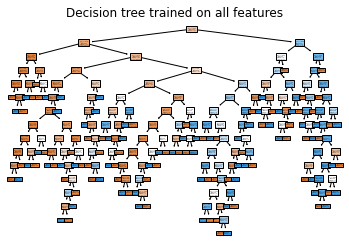

In [75]:
plt.figure()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all features")
plt.show()

Accuracy: 0.7467532467532467
Confusion matrix:
 [[90  6]
 [33 25]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82        96
           1       0.81      0.43      0.56        58

    accuracy                           0.75       154
   macro avg       0.77      0.68      0.69       154
weighted avg       0.76      0.75      0.72       154



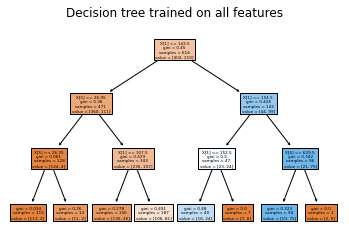

In [76]:
plt.figure()
clf = DecisionTreeClassifier(random_state=0,max_depth=3).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all features")
plt.show()

In [45]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=list(X.columns),  
                                class_names=['0', '1'],  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("pima-depth-3") 

'pima-depth-3.pdf'

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')
df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
df['BloodPressure.binned'] = pd.cut(df['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
df['BloodPressure.binned'] = df['BloodPressure.binned'].astype('int64')
df['SkinThickness.binned'] = pd.cut(df['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
df['SkinThickness.binned'] = df['SkinThickness.binned'].astype('int64')

In [74]:
cols = ['Glucose', 'BMI', 'Age']
gpt_bins = [[-1, 140, 200],[-1, 18.5, 25, 30, 68],[-1, 18, 35, 50, 65, 100],[-1, 25, 40, 55, 75, 100],]
binning_strategies = {
    'Glucose': [
        [-1, 100, 200],
        [-1, 50, 100, 150, 200],
        [-1, 105, 130, 1000],
        [-1, 95, 109, 125, 147, 1000],
        [-1, 140, 200],
        ],
    'BMI': [
        [-1, 34, 68],
        [-1, 17, 34, 41, 68],
        [-1, 29, 35, 68],
        [-1, 26, 30, 34, 38, 68],
        [-1, 18.5, 25, 30, 68],
        ],
    'Age': [
        [-1, 33, 66, 100],
        [-1, 25, 50, 75, 100],
        [-1, 23, 27, 33, 43, 100],
        [-1, 18, 35, 50, 65, 100],
        [-1, 25, 40, 55, 75, 100],
        ],
}
strategy_combos = list(itertools.product(*binning_strategies.values()))

In [75]:
x0 = []
x1 = []
x2 = []
x3 = []
results = []
for strategy in strategy_combos:
    # load data
    df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
    # bin fixed columns
    df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
    df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')
    df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
    df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
    df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
    df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
    df['BloodPressure.binned'] = pd.cut(df['BloodPressure'], bins=[-1, 60, 90, 100, 1000], labels=[60, 90, 100, 1000])
    df['BloodPressure.binned'] = df['BloodPressure.binned'].astype('int64')
    df['SkinThickness.binned'] = pd.cut(df['SkinThickness'], bins=[-1, 20, 40, 60, 80, 100], labels=[20, 40, 60, 80, 100])
    df['SkinThickness.binned'] = df['SkinThickness.binned'].astype('int64')
    # bin variable columns
    gpt_bin_count = 0
    for i in range(len(cols)):
        col = cols[i]
        bins = strategy[i]
        df[col + '.binned'] = pd.cut(df[col], bins=bins, labels=bins[1:])
        df[col + '.binned'] = df[col + '.binned'].astype('float64')
        if bins in gpt_bins: gpt_bin_count += 1
    # split data
    X = df[['Glucose.binned', 'Pregnancies.binned', 'Insulin.binned', 'BMI.binned', 'Age.binned',
            'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
    y = df['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    clf = DecisionTreeClassifier(random_state=0,max_depth=3).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print("Strategy:", strategy)
    print("Accuracy:", accuracy, "Strategy:", strategy)
    #print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    #print("Classification report:\n", classification_report(y_test, y_pred))
    results.append(accuracy)
    if gpt_bin_count == 0:
        x0.append(accuracy)
    elif gpt_bin_count == 1:
        x1.append(accuracy)
    elif gpt_bin_count == 2:
        x2.append(accuracy)
    elif gpt_bin_count == 3:
        x3.append(accuracy)
print("Number of results:", len(results))

Accuracy: 0.6623376623376623 Strategy: ([-1, 100, 200], [-1, 34, 68], [-1, 33, 66, 100])
Accuracy: 0.6493506493506493 Strategy: ([-1, 100, 200], [-1, 34, 68], [-1, 25, 50, 75, 100])
Accuracy: 0.6558441558441559 Strategy: ([-1, 100, 200], [-1, 34, 68], [-1, 23, 27, 33, 43, 100])
Accuracy: 0.6363636363636364 Strategy: ([-1, 100, 200], [-1, 34, 68], [-1, 18, 35, 50, 65, 100])
Accuracy: 0.6493506493506493 Strategy: ([-1, 100, 200], [-1, 34, 68], [-1, 25, 40, 55, 75, 100])
Accuracy: 0.6753246753246753 Strategy: ([-1, 100, 200], [-1, 17, 34, 41, 68], [-1, 33, 66, 100])
Accuracy: 0.6493506493506493 Strategy: ([-1, 100, 200], [-1, 17, 34, 41, 68], [-1, 25, 50, 75, 100])
Accuracy: 0.6623376623376623 Strategy: ([-1, 100, 200], [-1, 17, 34, 41, 68], [-1, 23, 27, 33, 43, 100])
Accuracy: 0.6493506493506493 Strategy: ([-1, 100, 200], [-1, 17, 34, 41, 68], [-1, 18, 35, 50, 65, 100])
Accuracy: 0.6493506493506493 Strategy: ([-1, 100, 200], [-1, 17, 34, 41, 68], [-1, 25, 40, 55, 75, 100])
Accuracy: 0.66

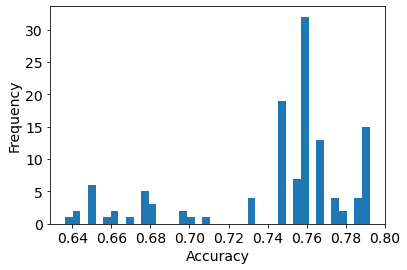

In [68]:
# create a histogram of the accuracy scores
plt.figure()
plt.hist(results, bins=40)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Frequency', size=14)
#plt.title('Decision tree accuracy', size=18)
plt.savefig(os.path.join(ppath, 'figs', 'pima-histogram.png'), dpi=300, bbox_inches="tight")
plt.show()

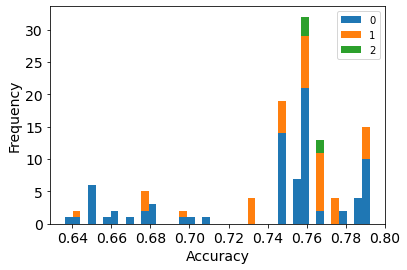

In [77]:
# create a histogram of the accuracy scores
plt.figure()
plt.hist([x0, x1, x2, x3], bins=40, stacked=True, label=['0', '1', '2', '3'])
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Frequency', size=14)
#plt.title('Decision tree accuracy', size=18)
plt.savefig(os.path.join(ppath, 'figs', 'pima-histogram-stacked.png'), dpi=300, bbox_inches="tight")
plt.show()

In [115]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
# Bin the data
df['Glucose.binned'] = pd.cut(df['Glucose'], bins=[-1, 140, 160, 200], labels=[140, 160, 200])
df['Glucose.binned'] = df['Glucose.binned'].astype('int64')
df['BMI.binned'] = pd.cut(df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100], labels=[18.5, 24.9, 29.9, 100])
df['BMI.binned'] = df['BMI.binned'].astype('int64')
df['Age.binned'] = pd.cut(df['Age'], bins=[-1, 18, 35, 50, 65, 100], labels=[18, 35, 50, 65, 100]) #0.72
df['Age.binned'] = pd.cut(df['Age'], bins=[-1, 20, 30, 40, 50, 100], labels=[0, 1, 2, 3, 4]) #0.75
df['Age.binned'] = pd.cut(df['Age'], bins=[-1, 25, 40, 55, 75, 100], labels=[0, 1, 2, 3, 4]) #0.75
#df['Age.binned'] = pd.cut(df['Age'], bins=[-1, 24, 30, 40, 50, 100], labels=[24, 30, 40, 50, 100]) #0.77
#df['Age.binned'] = pd.cut(df['Age'], bins=[-1, 20, 40, 60, 100], labels=[20, 40, 60, 100]) #0.72
df['Age.binned'] = df['Age.binned'].astype('int64')
df['Pregnancies.binned'] = pd.cut(df['Pregnancies'], bins=[-1, 2, 100], labels=[0, 1])
df['Pregnancies.binned'] = df['Pregnancies.binned'].astype('int64')
df['Insulin.binned'] = pd.cut(df['Insulin'], bins=[-1, 30, 120, 1000], labels=[30, 120, 1000])
df['Insulin.binned'] = df['Insulin.binned'].astype('int64')
df['DiabetesPedigreeFunction.binned'] = pd.cut(df['DiabetesPedigreeFunction'], bins=[-1, 0.5, 1, 100], labels=[0.5, 1, 100])
df['DiabetesPedigreeFunction.binned'] = df['DiabetesPedigreeFunction.binned'].astype('float64')

In [116]:
X = df[['Glucose.binned', 'Pregnancies.binned', 'Insulin.binned', 'BMI.binned', 'Age.binned',
        'BloodPressure.binned', 'DiabetesPedigreeFunction.binned', 'SkinThickness.binned']]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Accuracy: 0.7662337662337663
Confusion matrix:
 [[91  5]
 [31 27]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.83        96
           1       0.84      0.47      0.60        58

    accuracy                           0.77       154
   macro avg       0.79      0.71      0.72       154
weighted avg       0.78      0.77      0.75       154



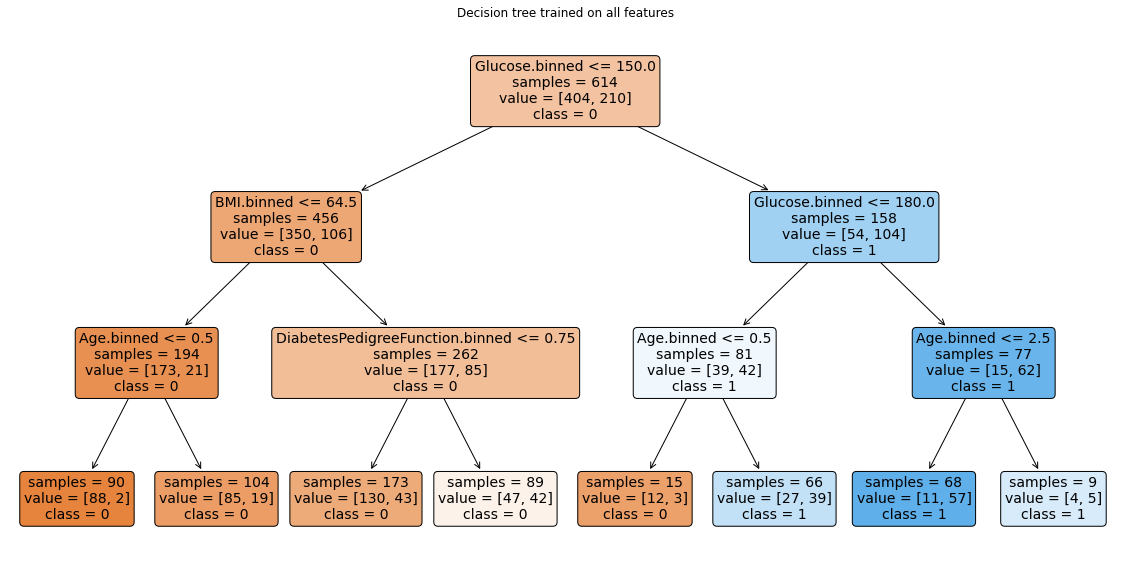

In [117]:
# plot size
plt.figure(figsize=(20,10))
clf = DecisionTreeClassifier(random_state=0,max_depth=3).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=['0', '1'], rounded=True, fontsize=14, label='all', impurity = False)
plt.title("Decision tree trained on all features")
plt.show()

In [85]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=list(X.columns),  
                                class_names=['0', '1'],  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("pima-high-accuracy-good-bins") 

'pima-high-accuracy-good-bins.pdf'

In [84]:
nan_rows = df[df['BMI.binned'].isnull()]
nan_rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose.binned,BMI.binned
120,0,162,76,56,100,53.2,0.759,25,1,2,NaN
125,1,88,30,42,99,55.0,0.496,26,1,0,NaN
177,0,129,110,46,130,67.1,0.319,26,1,0,NaN
193,11,135,0,0,0,52.3,0.578,40,1,0,NaN
247,0,165,90,33,680,52.3,0.427,23,0,2,NaN
303,5,115,98,0,0,52.9,0.209,28,1,0,NaN
445,0,180,78,63,14,59.4,2.420,25,1,2,NaN
673,3,123,100,35,240,57.3,0.880,22,0,0,NaN
